# Orthogonalization GLM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Suppose we have a dataset with two predictors, one trial (signal) predictor (index 0) and one noise predictor (index 1) and a dependent variable simulated as a linear combination of the two predictors with equal weights ($\beta = 1$ for both) plus some normally distributed noise. Note that there is a correlation between the predictors ($r = 0.5$).

In [93]:
N = 200
K = 1
P = 2
σ = 1

ΣX = np.array([[1, 0.5], [0.5, 1]])
μX = np.zeros(P)
X = np.random.multivariate_normal(μX, ΣX, size=N)
β = np.ones((P, K))
ϵ = np.random.normal(0, σ, size=(N, K))
y = X @ β + ϵ

Now, if we'd estimate the parameters ($\hat{\beta}$) for both predictors across a number of iterations (with independently generated noise, $\epsilon$), we'll see that their average approximates the true parameters ($\beta$), as the GLM is an unbiased estimator:

In [101]:
# Let's also keep track of R2
def get_r2(y, yhat):
    y = y.squeeze()
    return 1 - (np.sum((y - yhat) ** 2) / np.sum((y - y.mean()) ** 2))

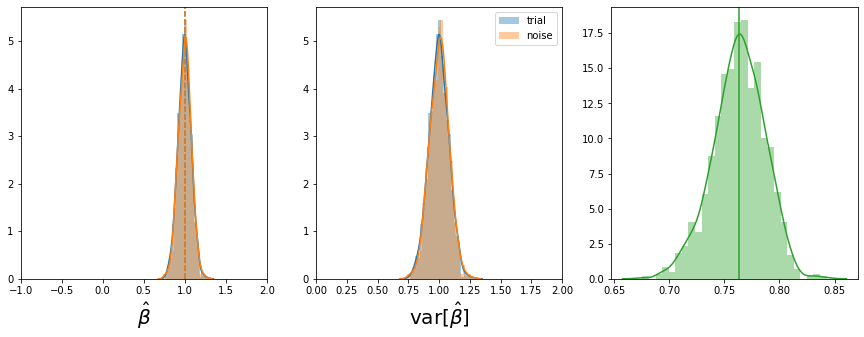

In [102]:
iters = 1000
β̂ = np.zeros((iters, P))
r2 = np.zeros(iters)

for i in range(iters):
    ϵ = np.random.normal(0, σ, size=(N, K))
    y = X @ β + ϵ
    β̂[i, :] = (np.linalg.pinv(X.T @ X) @ X.T @ y).squeeze()
    r2[i] = get_r2(y, X @ β̂[i, :])

def plot_stats(β̂, β, r2):
    
    if β̂.ndim == 1:
        β̂ = β̂[:, np.newaxis]

    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    sns.distplot(β̂[:, 0], ax=axes[0])
    axes[0].axvline(β̂[:, 0].mean(), ls='--')
    
    if β̂.shape[1] == 2:
        sns.distplot(β̂[:, 1], ax=axes[0])
        axes[0].axvline(β̂[:, 1].mean(), ls='--', c='tab:orange')
    
    axes[0].set_xlim(-1, 2)
    axes[0].set_xlabel(r'$\hat{\beta}$', fontsize=20);

    sns.distplot(β̂[:, 0], ax=axes[1])
    if β̂.shape[1] == 2:
        sns.distplot(β̂[:, 1], ax=axes[1])
    
    labels = ['trial', 'noise'] if β̂.shape[1] == 2 else ['trial']
    axes[1].legend(labels)
    axes[1].set_xlim(0, 2)
    axes[1].set_xlabel(r'$\mathrm{var}[\hat{\beta}]$', fontsize=20);

    sns.distplot(r2, ax=axes[2], color='tab:green')
    axes[2].axvline(r2.mean(), c='tab:green')

plot_stats(β̂, β, r2)

Now, what will happen if we orthogonalize the noise predictor with respect to our trial predictor? That is, what happens if we regress out all variance in our trial predictor that is related to the noise predictor? Unintuitively, this will give us *the same estimated parameter for our trial predictor (but not our noise predictor)*:

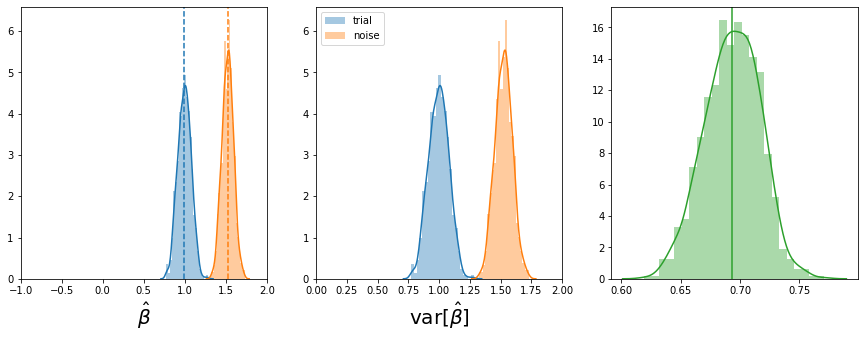

In [104]:
β̂ = np.zeros((iters, P))

for i in range(iters):
    ϵ = np.random.normal(0, 1, size=(N, K))
    y = X @ β + ϵ
    Xc = X.copy()
    # Regress out noise from trial predictor
    Xc[:, 0] -= X[:, 1, np.newaxis] @ np.linalg.lstsq(X[:, 1, np.newaxis], X[:, 0], rcond=None)[0]
    β̂[i, :] = (np.linalg.pinv(Xc.T @ Xc) @ Xc.T @ y).squeeze()
    r2[i] = get_r2(y, X @ β̂[i, :])
    
plot_stats(β̂, β, r2)

This is because the noise predictor will now "soak up" all the explained variance that was previously "discarded" (for lack of a better term). Note that this also happens when you "orthogonalize" in a different manner by removing the variance of the noise predictor from our dependent variable ($y$). Note that we're still including the noise predictor in our model (although it's variance is removed from our dependent variable):

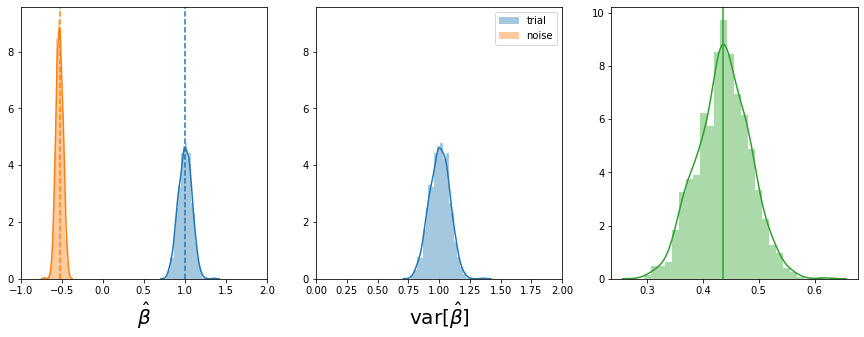

In [105]:
β̂ = np.zeros((iters, P))

for i in range(iters):
    ϵ = np.random.normal(0, 1, size=(N, K))
    y = X @ β + ϵ
    y -= X[:, 1, np.newaxis] @ np.linalg.lstsq(X[:, 1, np.newaxis], y, rcond=None)[0]
    β̂[i, :] = (np.linalg.pinv(X.T @ X) @ X.T @ y).squeeze()
    r2[i] = get_r2(y, X @ β̂[i, :])
    
plot_stats(β̂, β, r2)

Again, the parameter for our trial predictor (in blue) remains unbiased, but our noise predictor parameter suddenly becomes negative (~0.45), because it becomes a *suppressor*: it removes the variance in the signal predictor that is related to the noise. Note that the average noise parameter is the same as the covariance between the signal and the noise predictor (but negated):

In [106]:
np.cov(X.T)

array([[1.0496016 , 0.54562584],
       [0.54562584, 1.05694411]])

Also note that the $R^2$ values become much lower, but this is because we have discarded the variance from the target ($y$) related to the noise predictor before fitting the "final" model, but this already-explained variance is not part of the $R^2$ value here.

Interestingly, the model *does* become biased when you leave out the noise predictor after only removing its variance from the dependent variable (and not from the trial predictor), probably because the noise predictor cannot "suppress" the trial predictor any more:

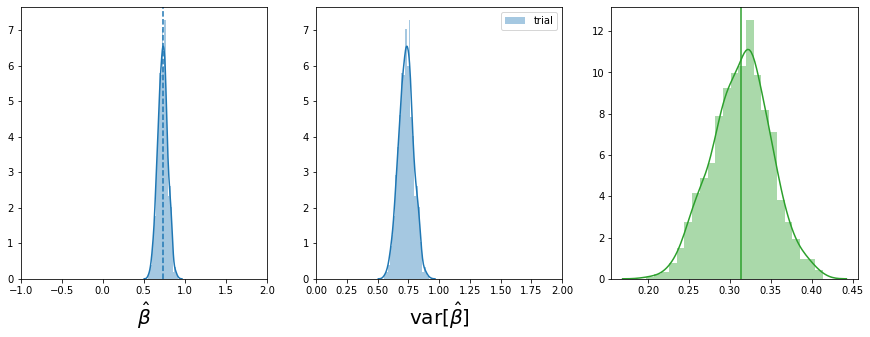

In [108]:
β̂ = np.zeros(iters)

for i in range(iters):
    ϵ = np.random.normal(0, 1, size=(N, K))
    y = X @ β + ϵ
    y -= X[:, 1, np.newaxis] @ np.linalg.lstsq(X[:, 1, np.newaxis], y, rcond=None)[0]
    Xc = X[:, 0, np.newaxis]  # leave out noise predictor
    β̂[i] = (np.linalg.pinv(Xc.T @ Xc) @ Xc.T @ y).squeeze()
    r2[i] = get_r2(y, Xc.squeeze() * β̂[i])
    
plot_stats(β̂, β, r2)

Note that when we regress the noise predictor out from both our trial predictor *and* our dependent variable, this bias disappears:

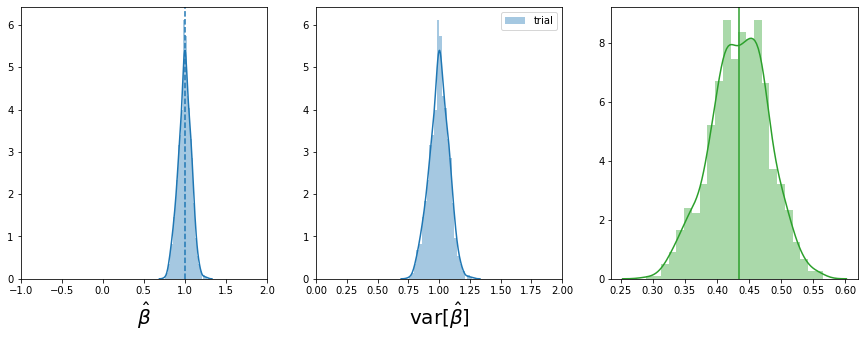

In [109]:
β̂ = np.zeros(iters)

for i in range(iters):
    ϵ = np.random.normal(0, 1, size=(N, K))
    y = X @ β + ϵ
    y -= X[:, 1, np.newaxis] @ np.linalg.lstsq(X[:, 1, np.newaxis], y, rcond=None)[0]
    Xc = X.copy()
    Xc[:, 0] -= X[:, 1, np.newaxis] @ np.linalg.lstsq(X[:, 1, np.newaxis], X[:, 0], rcond=None)[0]
    Xc = Xc[:, 0, np.newaxis]
    β̂[i] = (np.linalg.pinv(Xc.T @ Xc) @ Xc.T @ y).squeeze()
    r2[i] = get_r2(y, Xc.squeeze() * β̂[i])
    
plot_stats(β̂, β, r2)

What have we learned? If you're only interested in the trial effect ($\beta$), it doesn't matter if you include everything in the same model or you regress it out from the trial predictor, but regressing it out from only the dependent variable creates bias!